### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, restoration, filters

# Modules
from RICM_VESICLE import RICM

# Functions
def avg_movie(movie, l=2, show_dim=True):
    
    # Average each l frames
    movie_consecutive = []
    for i in range(int(movie.shape[0])):
        if movie.shape[0] - i >= l:
            movie_consecutive.append(np.mean(movie[i:i+l], axis=0))

    # Transform the movie into numpy array
    movie_consecutive = np.array(movie_consecutive)
    
    # Show the dimension reduction
    if show_dim == True:
        print("{} --> {}".format(movie.shape, movie_consecutive.shape))
    
    return movie_consecutive

### Determine the Movie

In [2]:
# Determine the Experiment, Shot and the GUV number
EXPERIMENT = 'Movies'
DATA = 'MAK_RICM_Long_Mov_CHN10_100_220170403_71618 PM'
SHOT, GUV = "", 1

### Read the whole RICM image to determine the base line

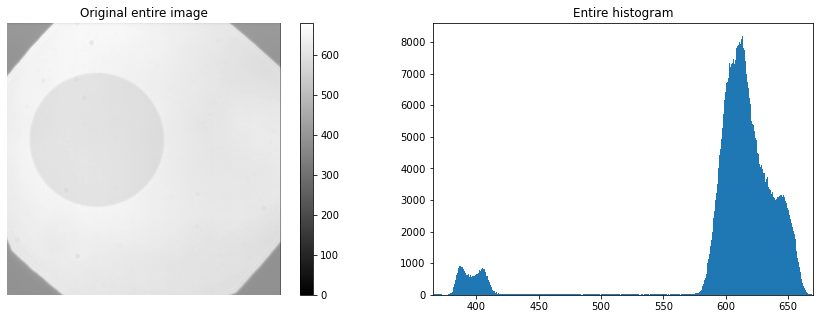

In [3]:
# Read the RICM image
RICM_img = io.imread("{}/data/{}.tif".format(EXPERIMENT, DATA))[-100:].mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(RICM_img, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(RICM_img.ravel(), bins = 1000);
plt.xlim(365,670);

### Read the RICM image for one GUV

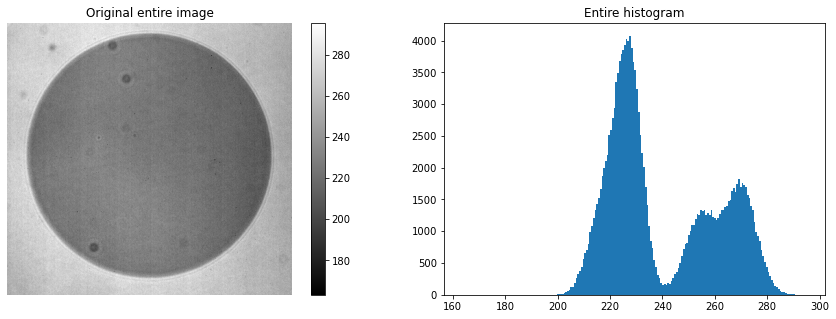

In [4]:
# Read the image
guv = io.imread("{}/data/{}{}-{}.tif".format(EXPERIMENT,DATA, SHOT, GUV))[380:]

# Subtract the base line
guv = guv - 375

# Take the average
guv_avg = guv[-100:].mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(guv_avg.ravel(), bins = 200);

### Define the RICM model to get the bacground corrected image

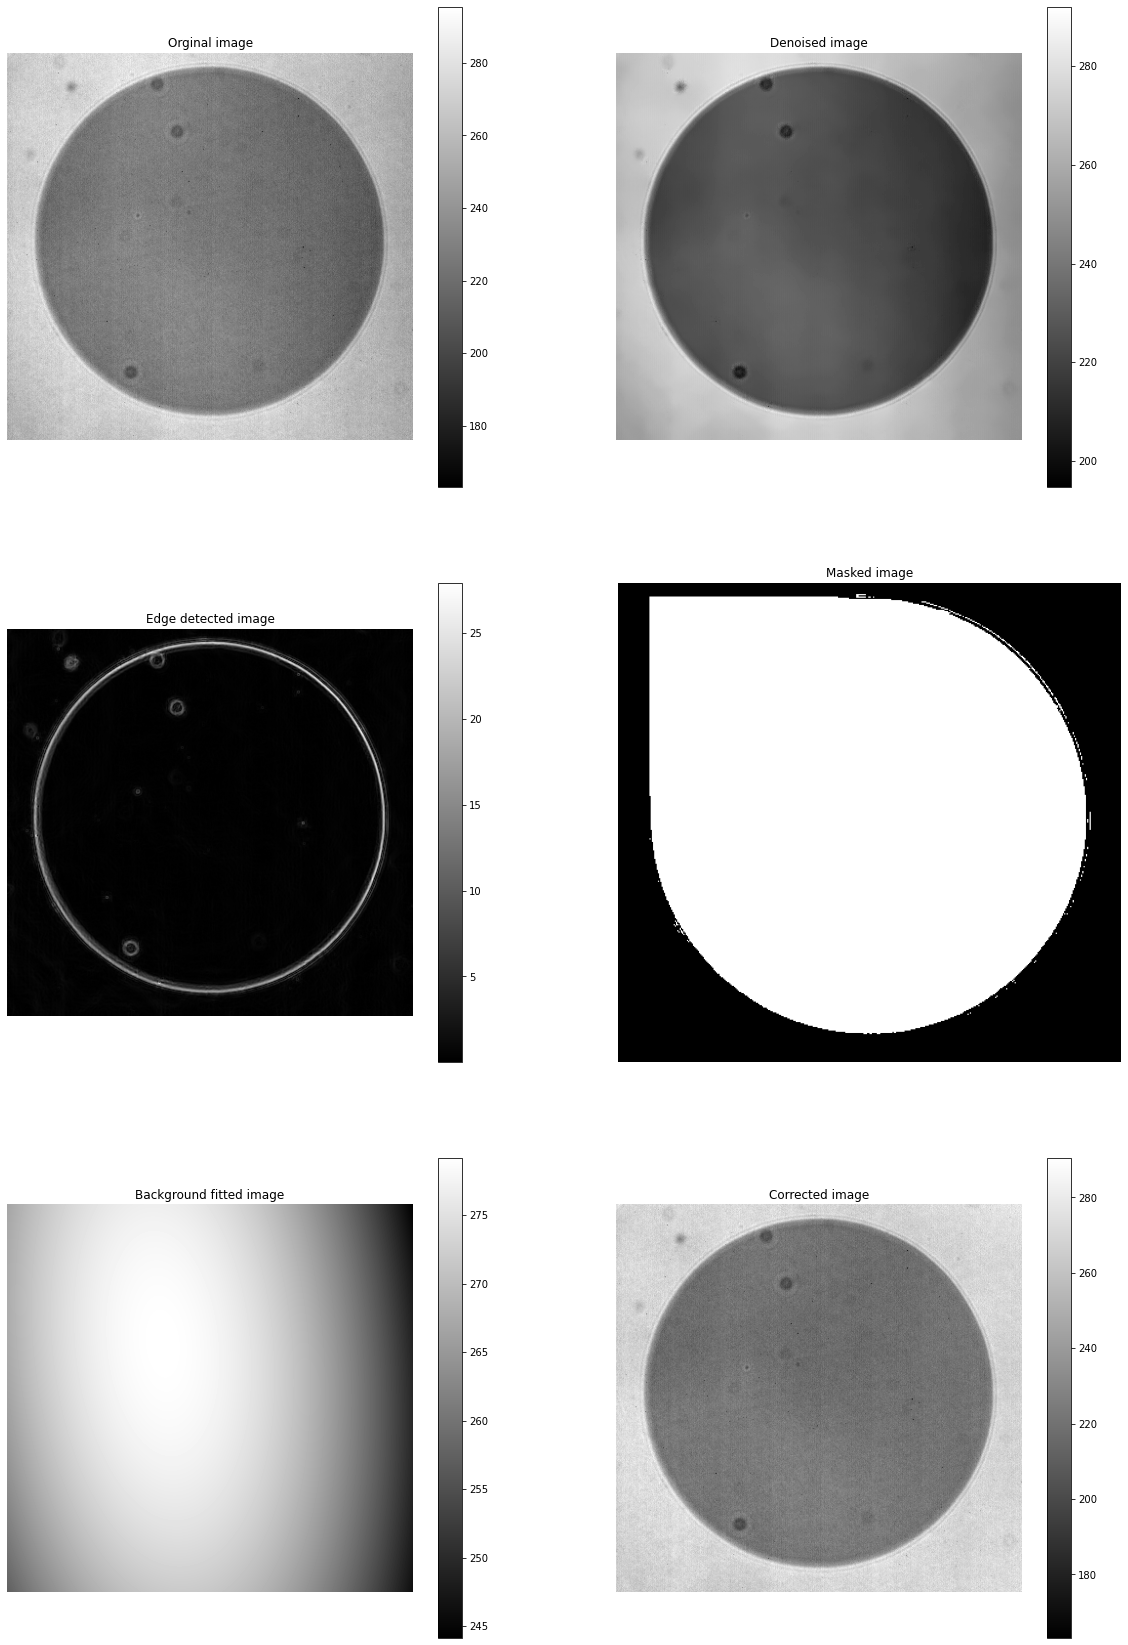

In [5]:
# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# display results
plt.figure(figsize=(20,30))

plt.subplot(321)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(322)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(323)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(325)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar();

### The histogram of the corrected GUV

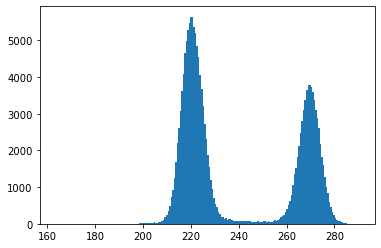

In [6]:
plt.hist(ricm.correct().ravel(), bins = 200);

### Take a cosecutive average of the GUV movie

In [7]:
# Take a cosecutive average
guv_consecutive = avg_movie(guv, l=6)

(2120, 397, 416) --> (2115, 397, 416)


### Measure the area of each frame
#### With background correction

In [8]:
%%time

# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# Define the background
background = ricm.background_fitting()
background_correction = background.mean() - background

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1] , multichannel = False))

# Get the area of each frame in the averaged movie
area = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm on the background corrected image
    img_corrected = restoration.denoise_nl_means(guv_consecutive[i] + background_correction,
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)

    # Compute the area
    area.append((1 - np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1)).sum())

# Transform the area into normalized numpy array
area = np.array(area)

CPU times: user 1h 14min 52s, sys: 948 ms, total: 1h 14min 53s
Wall time: 1h 14min 54s


#### Without background correction

In [ ]:
%%time

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1] , multichannel = False))

# Get the area of each frame in the averaged movie
area = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm
    img_denoised = restoration.denoise_nl_means(guv_consecutive[i],
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)

    # Compute the area
    area.append((1 - np.multiply(img_denoised > filters.threshold_otsu(img_denoised), 1)).sum())

# Transform the area into normalized numpy array
area = np.array(area)

### Plote and save the area curves

(2115,) (2115,)


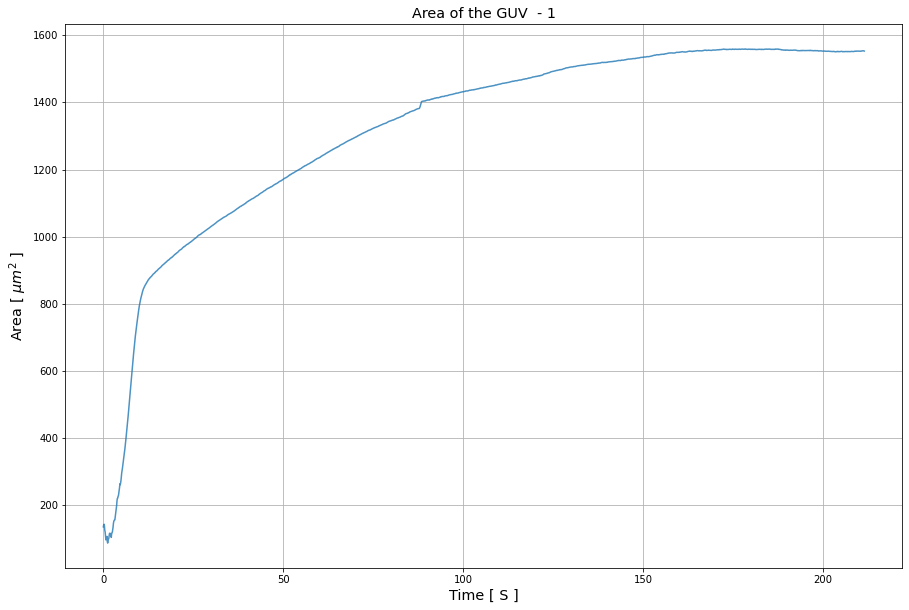

In [16]:
# Define the curve and the time interval
area_curve = area[:] * 0.125**2
#area_curve = area[:]
#area_curve = np.hstack((area[:600],
 #                       np.linspace(np.mean(area[580:600]),np.mean(area[600:620]),110),
  #                      area[600:1200],
   #                     np.linspace(np.mean(area[1180:1200]),np.mean(area[1200:1220]),160),
    #                    area[1200:])) * 0.125**2

time = np.arange(0, area_curve.shape[0]*0.1, 0.1)

print(area_curve.shape, time.shape)

#time = np.hstack((np.arange(0, int(1200*0.1), 0.1), np.arange(int(1200*0.1)+1, int(1200*0.1)+1+2091*1, 1)))

# Define data frame for the scaled time and area
df = pd.DataFrame(data={'Time':time, 'Area':area_curve})

# Plot the curve
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], df['Area'], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [ S ]', fontsize = "x-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "x-large")
plt.grid()
plt.savefig("{}/results/{}{}-{}".format(EXPERIMENT, DATA, SHOT, GUV))

# Save the data
df.to_csv("{}/results/{}{}-{}.csv".format(EXPERIMENT, DATA, SHOT, GUV), index=False)

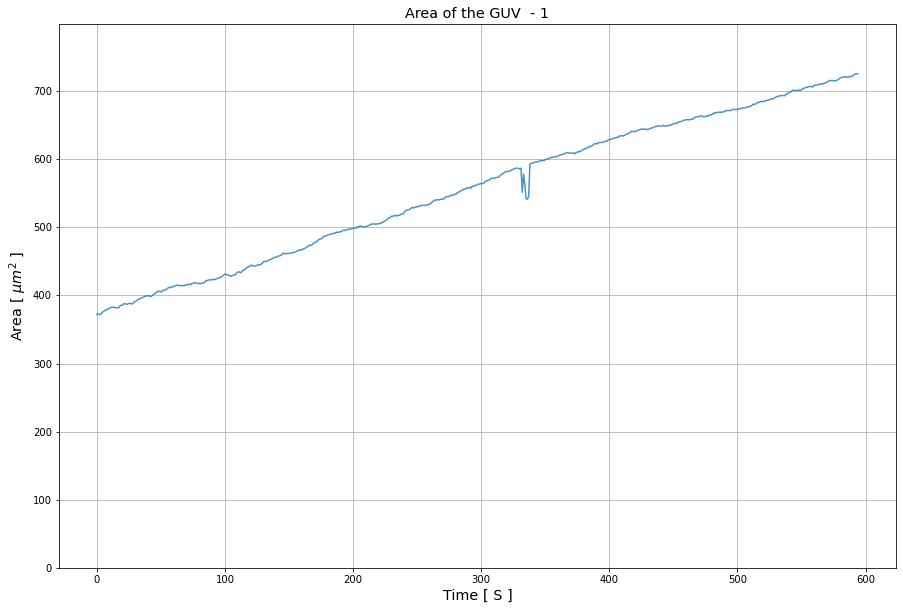

In [10]:
# Plot the curve from zero
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], df['Area'], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [ S ]', fontsize = "x-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "x-large")
plt.ylim(0,df['Area'].max() + df['Area'].max()/10)
plt.grid()
plt.savefig("{}/results/{}{}-{}_FromZero".format(EXPERIMENT, DATA, SHOT, GUV))

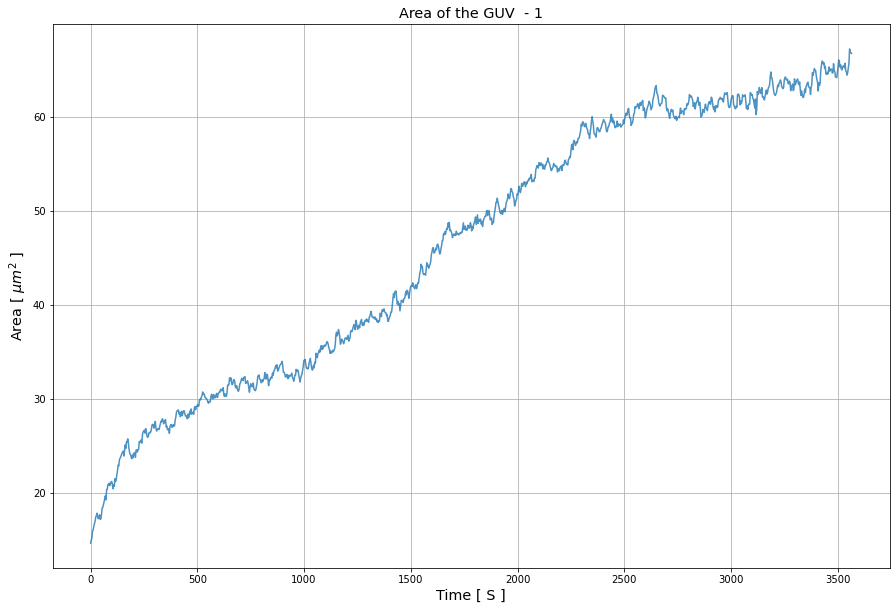

In [31]:
# Determine the Experiment, Shot and the GUV number
EXPERIMENT = '20210212_Ecad_dynamics'
DATA = 'movie-1200-3sec'
SHOT, GUV = "", 1

# Read the data frame of the scaled time and area
df = pd.read_csv('{}/results/{}{}-{}.csv'.format(EXPERIMENT, DATA, SHOT, GUV))

# Plot the curve from zero
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], df['Area'], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [ S ]', fontsize = "x-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "x-large")
#plt.ylim(0,df['Area'].max() + df['Area'].max()/10)
plt.grid()
plt.savefig("{}/results/{}{}-{}".format(EXPERIMENT, DATA, SHOT, GUV))

In [22]:
df['Time']

0          0
1          1
2          2
3          3
4          4
        ... 
1184    1184
1185    1185
1186    1186
1187    1187
1188    1188
Name: Time, Length: 1189, dtype: int64

In [23]:
np.arange(0, int(area_curve.shape[0]*3)-18, 3).shape

(1189,)

In [32]:
area[1180:1190].mean()

17190.7

In [28]:
area[1190:1200].mean()

18139.9

In [29]:
area[1200:1210].mean()

18880.5

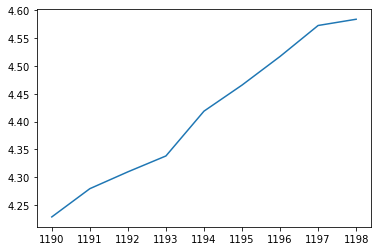

In [4]:
plt.plot(df['Area'][1190:1199] * 0.125**2);

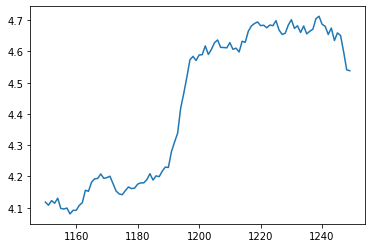

In [10]:
plt.plot(df['Area'][1150:1250] * 0.125**2);

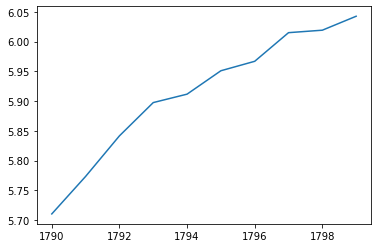

In [6]:
plt.plot(df['Area'][1790:1800] * 0.125**2);

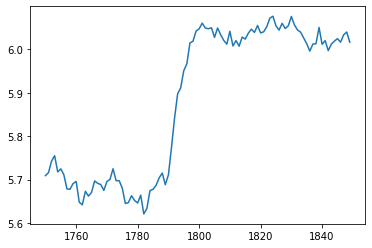

In [7]:
plt.plot(df['Area'][1750:1850] * 0.125**2);

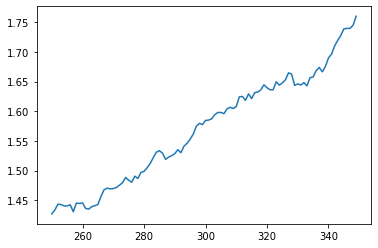

In [8]:
plt.plot(df['Area'][250:350] * 0.125**2);